In [35]:
pip install pandas matplotlib seaborn plotly requests


Note: you may need to restart the kernel to use updated packages.


In [36]:
import requests
import pandas as pd

AUTH_KEY = "94a870225adbe438cc846c2d69246d2971539f4f7ac7a64d"

headers = {
    'Content-Type': 'application/json',
    'Auth-Key': AUTH_KEY
}

data = {
    "query": "get_iocs",
    "days": 7
}

response = requests.post("https://threatfox-api.abuse.ch/api/v1/", headers=headers, json=data)


if response.status_code == 200:
    try:
        json_data = response.json()
        if json_data.get("query_status") == "ok":
            df = pd.DataFrame(json_data.get("data", []))
            print("✔ Dane poprawnie pobrane")
            print(df.head())
        else:
            print("⚠ Błąd API:", json_data.get("data"))
    except Exception as e:
        print("❌ Błąd dekodowania JSON:", e)
else:
    print(f"❌ Błąd HTTP: {response.status_code}")
    print(response.text)




✔ Dane poprawnie pobrane
        id                  ioc threat_type  \
0  1485186     85.239.62.195:80   botnet_cc   
1  1485185    85.239.62.195:443   botnet_cc   
2  1485184  38.132.122.163:8888   botnet_cc   
3  1485183    35.169.63.213:443   botnet_cc   
4  1485182     173.187.25.9:995   botnet_cc   

                                    threat_type_desc ioc_type  \
0  Indicator that identifies a botnet command&con...  ip:port   
1  Indicator that identifies a botnet command&con...  ip:port   
2  Indicator that identifies a botnet command&con...  ip:port   
3  Indicator that identifies a botnet command&con...  ip:port   
4  Indicator that identifies a botnet command&con...  ip:port   

                                       ioc_type_desc          malware  \
0  ip:port combination that is used for botnet Co...      win.rhysida   
1  ip:port combination that is used for botnet Co...      win.rhysida   
2  ip:port combination that is used for botnet Co...  win.eye_pyramid   
3  ip:por

In [37]:
# Konwersja kolumn daty
df['first_seen'] = pd.to_datetime(df['first_seen'], errors='coerce')
df['last_seen'] = pd.to_datetime(df['last_seen'], errors='coerce')

# Usunięcie duplikatów (np. po kolumnie 'ioc')
df.drop_duplicates(subset=['ioc'], inplace=True)

# Sprawdzenie braków
print(df.isnull().sum())



id                       0
ioc                      0
threat_type              0
threat_type_desc         0
ioc_type                 0
ioc_type_desc            0
malware                  0
malware_printable        0
malware_alias          918
malware_malpedia         0
confidence_level         0
first_seen               0
last_seen            23229
reference              321
reporter                 0
tags                    33
dtype: int64


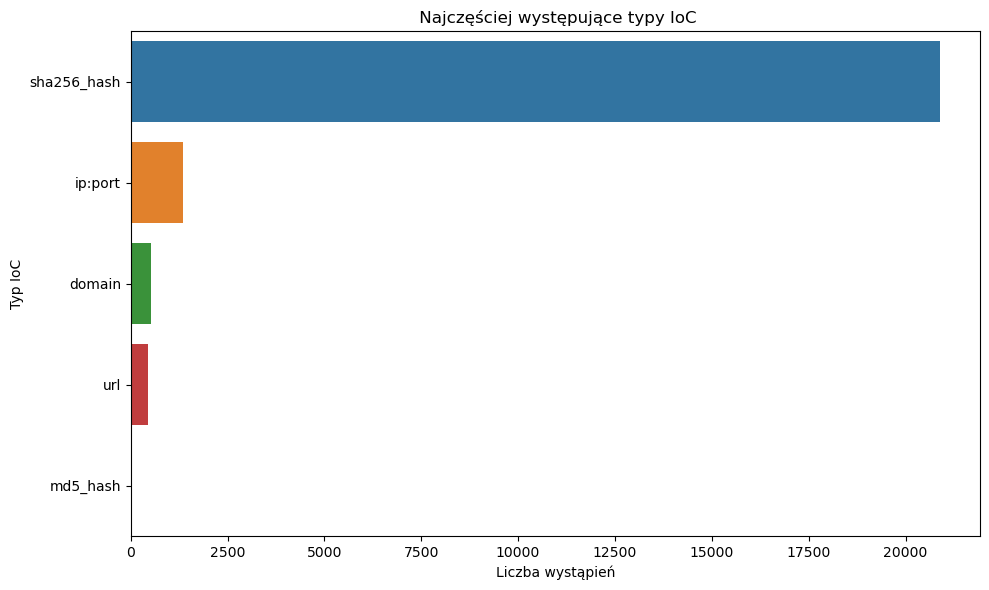

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='ioc_type', order=df['ioc_type'].value_counts().index)
plt.title(" Najczęściej występujące typy IoC")
plt.xlabel("Liczba wystąpień")
plt.ylabel("Typ IoC")
plt.tight_layout()
plt.show()


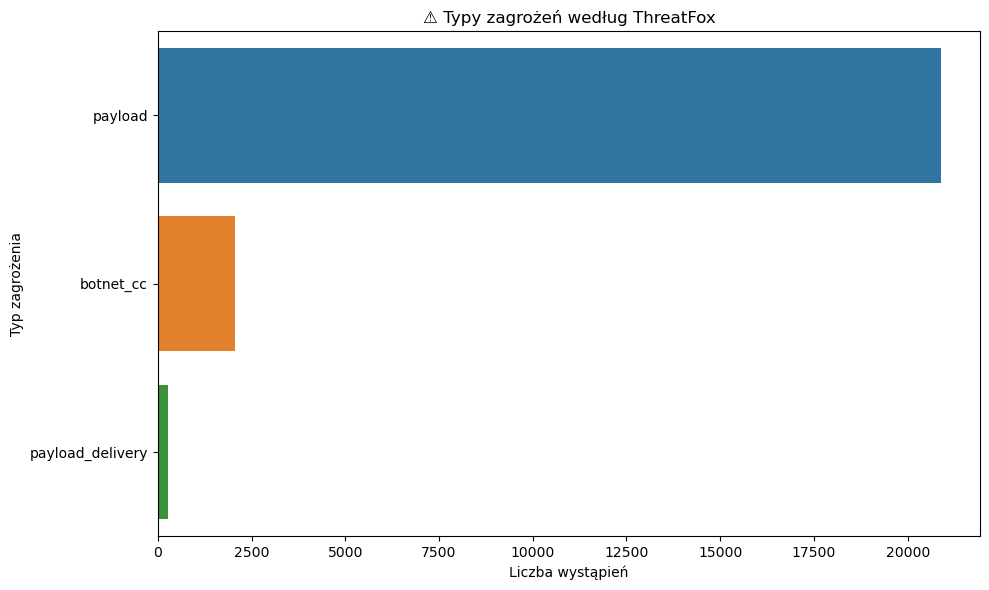

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='threat_type', order=df['threat_type'].value_counts().index)
plt.title("⚠ Typy zagrożeń według ThreatFox")
plt.xlabel("Liczba wystąpień")
plt.ylabel("Typ zagrożenia")
plt.tight_layout()
plt.show()


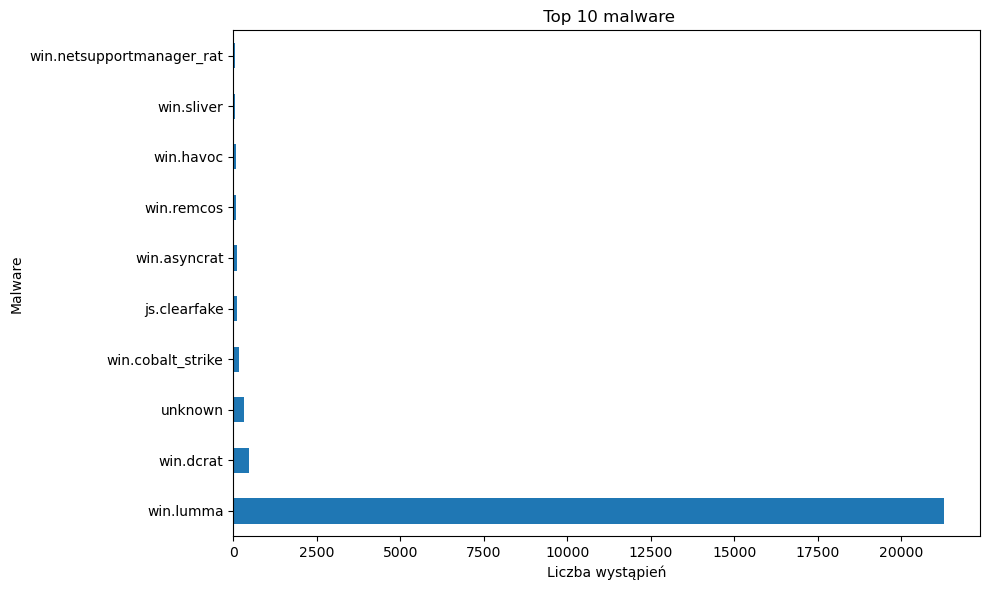

In [40]:
if 'malware' in df.columns:
    top_malware = df['malware'].value_counts().head(10)
    top_malware.plot(kind='barh', figsize=(10, 6), title=' Top 10 malware')
    plt.xlabel("Liczba wystąpień")
    plt.ylabel("Malware")
    plt.tight_layout()
    plt.show()


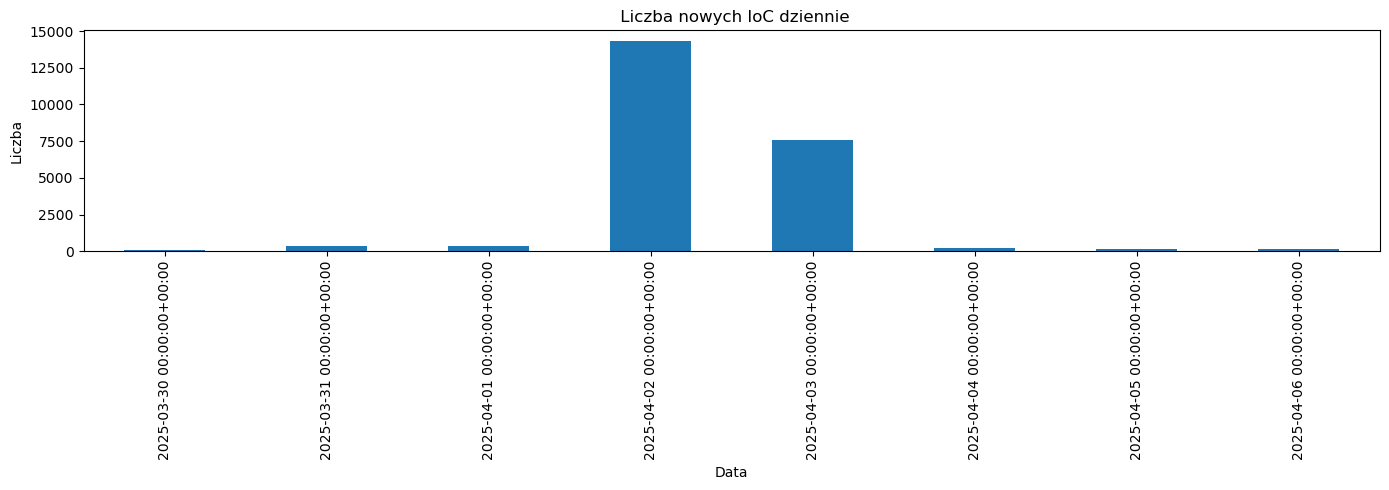

In [41]:
df.set_index('first_seen').resample('D').size().plot(kind='bar', figsize=(14, 5))
plt.title(" Liczba nowych IoC dziennie")
plt.ylabel("Liczba")
plt.xlabel("Data")
plt.tight_layout()
plt.show()


In [11]:

daily_iocs = df.set_index('first_seen').resample('D').size().rename("ioc_count").reset_index()
daily_iocs = daily_iocs[daily_iocs['ioc_count'] > 0]  


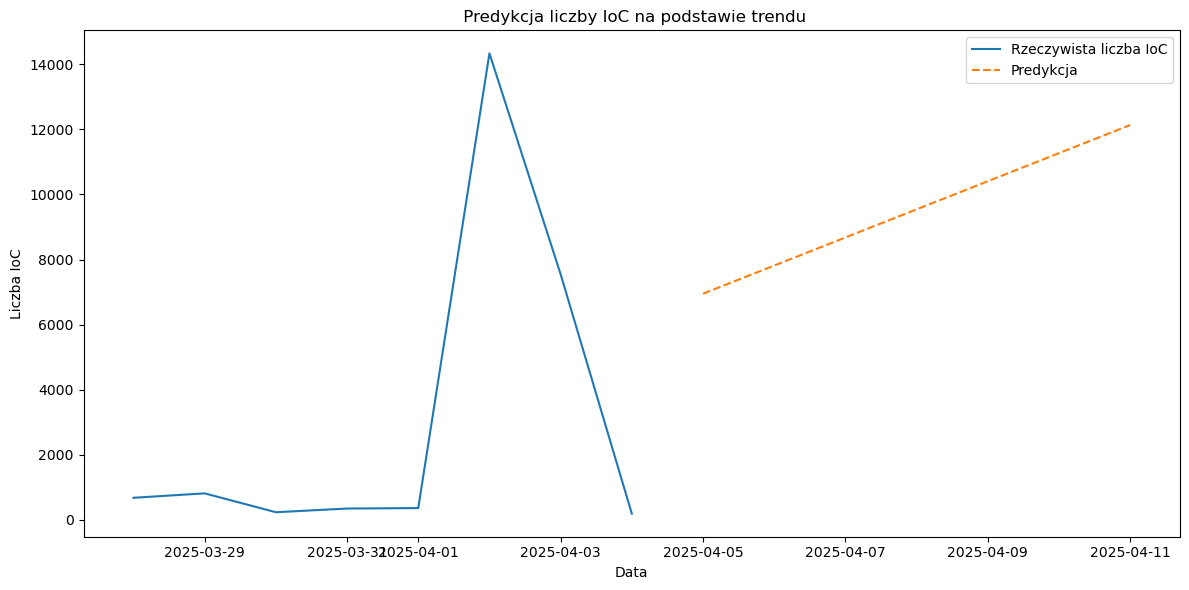

In [46]:
import numpy as np
from sklearn.linear_model import LinearRegression


daily_iocs['days_since_start'] = (daily_iocs['first_seen'] - daily_iocs['first_seen'].min()).dt.days


X = daily_iocs[['days_since_start']]
y = daily_iocs['ioc_count']
model = LinearRegression().fit(X, y)


future_days = pd.DataFrame({'days_since_start': range(X['days_since_start'].max() + 1, X['days_since_start'].max() + 8)})
preds = model.predict(future_days)


plt.figure(figsize=(12, 6))
plt.plot(daily_iocs['first_seen'], y, label='Rzeczywista liczba IoC')
plt.plot(
    pd.date_range(daily_iocs['first_seen'].max() + pd.Timedelta(days=1), periods=7),
    preds, label='Predykcja', linestyle='--'
)
plt.title(" Predykcja liczby IoC na podstawie trendu")
plt.xlabel("Data")
plt.ylabel("Liczba IoC")
plt.legend()
plt.tight_layout()
plt.show()




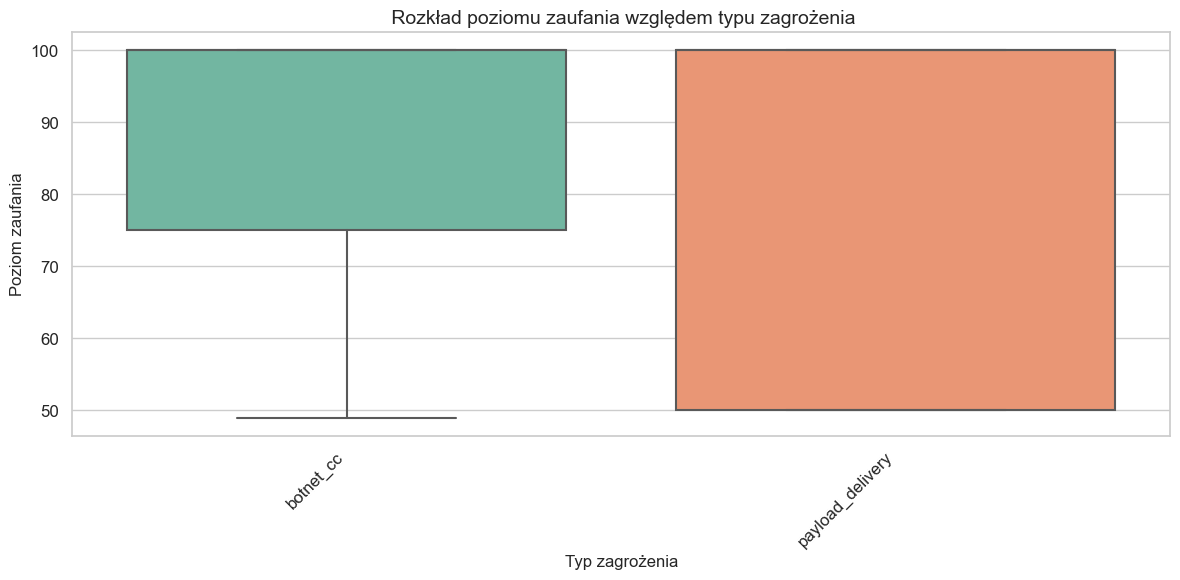

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")  
sns.set_context("notebook", font_scale=1.1) 


df_filtered = df[
    df['confidence_level'].notnull() &
    df['threat_type'].notnull() &
    (df['threat_type'] != 'payload')  
]


plt.figure(figsize=(12, 6))
sns.boxplot(
    x="threat_type",
    y="confidence_level",
    data=df_filtered,
    palette="Set2"
)


plt.title(" Rozkład poziomu zaufania względem typu zagrożenia", fontsize=14)
plt.xlabel("Typ zagrożenia", fontsize=12)
plt.ylabel("Poziom zaufania", fontsize=12)


plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()



In [67]:
pip install wordcloud


   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/299.9 kB ? eta -:--:--
   -- ------------------------------------ 20.5/299.9 kB 222.6 kB/s eta 0:00:02
   ------- ------------------------------- 61.4/299.9 kB 469.7 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/299.9 kB 853.3 kB/s eta 0:00:01
   ---------------------------------------  297.0/299.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 299.9/299.9 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


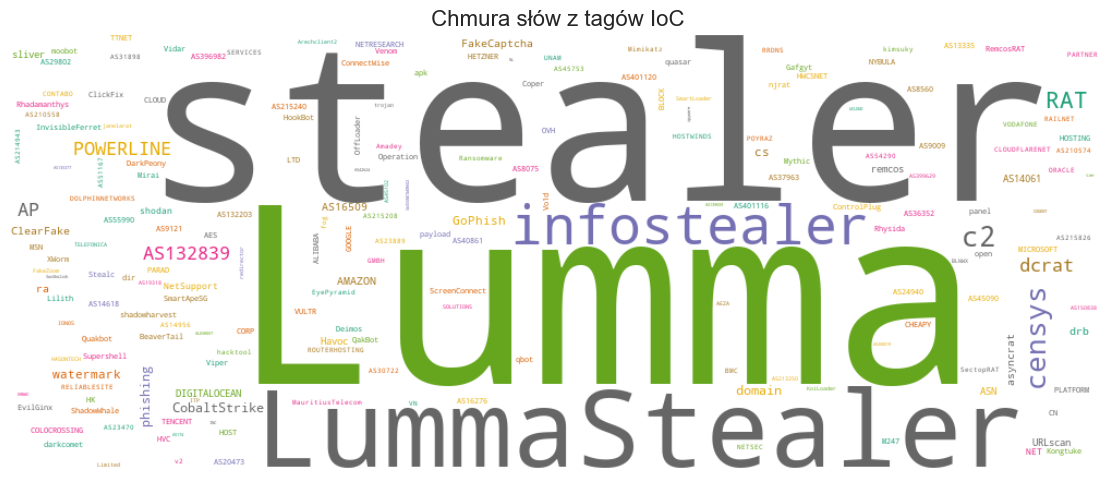

In [69]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


tags_text = df['tags'] \
    .dropna() \
    .astype(str) \
    .str.replace(r"[\[\]\'\"]", "", regex=True) \
    .str.cat(sep=",") \
    .replace(",,", ",")


wordcloud = WordCloud(
    width=1000,
    height=400,
    background_color='white',
    colormap='Dark2',
    collocations=False
).generate(tags_text)


plt.figure(figsize=(14, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(" Chmura słów z tagów IoC", fontsize=16)
plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

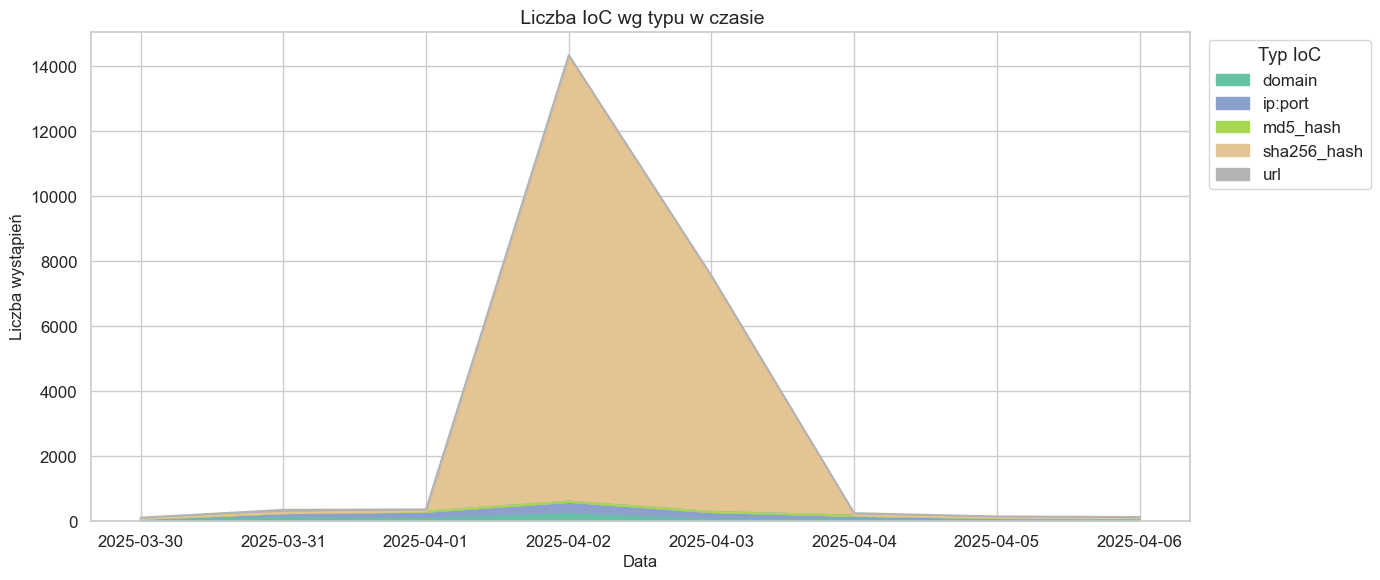

In [76]:
import pandas as pd
import matplotlib.pyplot as plt


df['first_seen'] = pd.to_datetime(df['first_seen'], errors='coerce')
df['date'] = df['first_seen'].dt.date 


ioc_counts = df.groupby(['date', 'ioc_type']).size().unstack(fill_value=0)


plt.figure(figsize=(14, 6))
ioc_counts.plot.area(stacked=True, colormap='Set2', figsize=(14, 6))


plt.title(" Liczba IoC wg typu w czasie", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Liczba wystąpień", fontsize=12)
plt.legend(title="Typ IoC", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


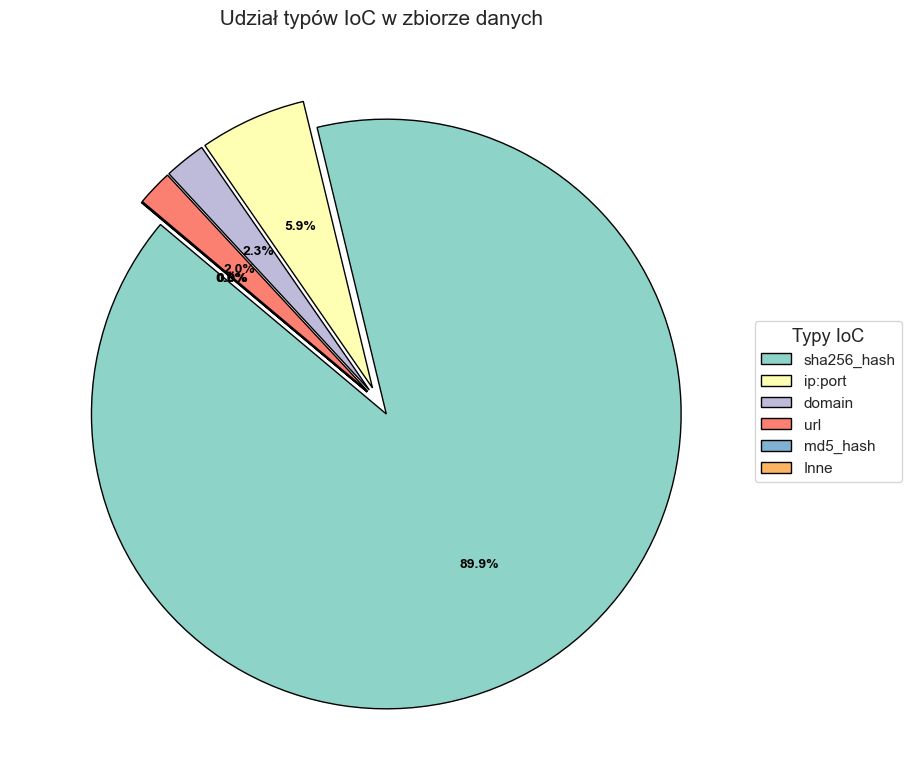

In [82]:
import matplotlib.pyplot as plt


ioc_counts = df['ioc_type'].value_counts()


top_n = 6
top_iocs = ioc_counts[:top_n]
others = ioc_counts[top_n:].sum()
ioc_labels = list(top_iocs.index) + ['Inne']
ioc_values = list(top_iocs.values) + [others]


explode = [0.05] * len(ioc_labels)


colors = plt.get_cmap('Set3').colors


fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(
    ioc_values,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 11}
)


ax.legend(
    wedges,
    ioc_labels,
    title="Typy IoC",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=11
)


plt.setp(autotexts, size=10, weight="bold", color="black")
plt.title(" Udział typów IoC w zbiorze danych", fontsize=15)
plt.tight_layout()
plt.show()
